## Grab the data from excel

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import wrap
import seaborn as sns
%matplotlib inline

In [2]:
#initial cleaning function
def clean_sheet(dataframe):
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj

In [3]:
# add a function to grab country
def get_country(ticker):
    if type(ticker)==str:
        return ticker[-2:]
    else:
        return None

In [129]:
#pull the data from excel, form a dictionary of tab names and dataframes
tabs_to_grab=['Quarter','Date','Revision','Market cap','Volume','PE','PE premium','Property']

# Europe
data_dict_Europe={}

for s in tabs_to_grab:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe 2007-2017.xlsx',sheet_name=s))
    data_dict_Europe[s]=df
    
# select the right universe for Europe
universe_evaluate_Europe=(data_dict_Europe["Market cap"]>500)&(data_dict_Europe["Volume"]>5)
data_dict_Europe["Revision"]=data_dict_Europe["Revision"][universe_evaluate_Europe]
data_dict_Europe["Market cap"]=data_dict_Europe["Market cap"][data_dict_Europe["Market cap"]>500]

In [130]:
# US
data_dict_US={}

for s in tabs_to_grab:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\US 2007-2017.xlsx',sheet_name=s))
    df["country"]=df.apply(lambda x:get_country(x.name),axis=1)
    df=df[df["country"]!='CN']
    del df['country']
    data_dict_US[s]=df

# select the right universe for US
universe_evaluate_US=(data_dict_US["Market cap"]>1000)&(data_dict_US["Volume"]>5)
data_dict_US["Revision"]=data_dict_US["Revision"][universe_evaluate_US]
data_dict_US["Market cap"]=data_dict_US["Market cap"][data_dict_US["Market cap"]>1000]

In [131]:
# global
data_dict_global={}

for s in tabs_to_grab:
    df=pd.concat([data_dict_Europe[s],data_dict_US[s]],axis=0)
    data_dict_global[s]=df

In [52]:
# get the price dataframe for certain years; form the price and return datetime from the data from all the years 
def price_from_excel(path, start_year,end_year):
    
    year_range=range(start_year,end_year+1)

    price_list=[]

    for year in year_range:
        price_year=clean_sheet(pd.read_excel(path,sheet_name=str(year))).dropna(how='all',axis=0)
        price_list.append(price_year)

    price=pd.concat(price_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')

    # transform the datetime to the common timestamp format
    price_column=[i.strftime("%d/%b/%Y") for i in price.columns.tolist() if type(i)!=str]
    price.columns=price_column
    
    return price

In [53]:
# get price_df
price_Europe=price_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe price 2007-2018.xlsx',2007,2017)
price_US=price_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\US price 2007-2018.xlsx',2007,2017)

In [54]:
def get_return(price_df,benchmark):
    rel_price=price_df/price_df.loc[benchmark]
    rel_price=rel_price.dropna(how='all',axis=0)
    abs_return=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
    abs_return=abs_return.dropna(how='all',axis=0)
    rel_return=abs_return - abs_return.loc[benchmark]
    rel_return=rel_return.dropna(how='all',axis=0)
    return rel_price,abs_return,rel_return

In [191]:
# get return dfs
rel_price_Europe,abs_return_Europe,rel_return_Europe=get_rel_return(price_Europe,'SXXP Index')
rel_price_US,abs_return_US,rel_return_US=get_rel_return(price_US,'SPX Index')

## Utility functions for signal formation

In [13]:
# utility function to get volatility from return series
def vol_calc(return_series,vol_lookback,index0):
    hist=len(return_series[:index0])
    if hist<=vol_lookback:
        vol=return_series[:index0].std()
    else:
        vol=return_series[index0-vol_lookback-1:index0].std()
    return vol

In [14]:
# utility function to obtain announcement return (as a multiplier of vol) as a result of day 0 and return dataframe
def EAR_calc(single_date,return_series,EAR_period,vol_lookback):
    if type(single_date)==pd._libs.tslib.Timestamp:
        date_series=return_series.index.tolist()
        if single_date.strftime("%d/%b/%Y") in date_series:
            day0=date_series.index(single_date.strftime("%d/%b/%Y"))
            vol=vol_calc(return_series,vol_lookback,day0)
            if len(return_series.iloc[day0:])<EAR_period:
                ret=return_series[day0:].sum()
                nmove=ret/vol
            else:
                ret=return_series.iloc[day0:day0+EAR_period].sum()
                nmove=ret/vol
            return nmove
        else:
            return None
    else:
        return None

In [15]:
# obtain the announcement return dataframe from price return and date dataframe
def EAR_df(date_df,return_df,EAR_period,vol_lookback):
    EAR_list=[]
    for ticker, date_row in date_df.iterrows():
        if type(ticker)==str: #deal with 
            return_row=return_df.loc[ticker]
            ret_series=date_row.apply(lambda x: EAR_calc(x,return_row,EAR_period,vol_lookback))
            EAR_list.append(ret_series)
        else:
            pass
    EAR_df=pd.concat(EAR_list,axis=1).T
    return EAR_df

# Long signal build up

In [16]:
#signal formation (number 1) and use the date as the base dataframe
def signal1_formation(date_df,return_for_signal,EAR_period,EAR_low,EAR_high,revision_df,revision_low,revision_high):
    EAR_return=EAR_df(date_df,return_for_signal,EAR_period,30).fillna(0.0).reindex(revision_df.index.tolist())
    signal1_evaluate=(EAR_return>EAR_low)&(EAR_return<EAR_high) & (revision_df>revision_low)& (revision_df<revision_high)
    signal1=date_df[signal1_evaluate]
    signal1_next=date_df.shift(1,axis=1)[signal1_evaluate]
    return signal1,signal1_next

In [17]:
#Stack signals into a list of tuples (stocks, dates,next earnign dates, next signal dates), convert dates into a common format of datetime
def signal1_stacking(signal1,signal1_next):
    signal1_list=[]
    for ticker, row in signal1.iterrows():
        adj_row=row.dropna()
        if len(adj_row)!=0:
            for idx in range(len(row)):
                date=row.iloc[idx]
                date_next=signal1_next.loc[ticker].iloc[idx]
                if type(date)==pd._libs.tslib.Timestamp:
                    adj_date=date.strftime("%d/%b/%Y") #transform the datetime into a common format
                    loc_date=adj_row.tolist().index(date)
                    if (loc_date>0)&(len(adj_row)>0):
                        next_signal=adj_row.iloc[loc_date-1].strftime("%d/%b/%Y") 
                        adj_next_date=date_next.strftime("%d/%b/%Y") 
                    elif type(date_next)==pd._libs.tslib.Timestamp:
                        next_signal=None
                        adj_next_date=date_next.strftime("%d/%b/%Y") 
                    else:
                        next_signal=None
                        adj_next_date=None                
                    signal1_list.append((row.name,adj_date,adj_next_date,next_signal))
                else:
                    pass
        else:
            pass
    return signal1_list

# Signal result by day

In [18]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#; replace datetime with number of days post announcement to make it more comparable 
def signal1_dict_day(signal1_list,return_df,holding,earning,entry):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]       
        if (s[1] in return_series.index):
            if not np.isnan(return_series.loc[s[1]]): 
                day0=return_series.index.tolist().index(s[1]) #index of day 0
                if earning is True:
                    period=holding
                elif (type(s[2])==pd._libs.tslib.NaTType)|(s[2] is None):
                    period=holding
                else:
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y"))-entry)
                target_series=return_series.iloc[day0+entry:day0+min(period+entry, len(return_series[day0:]))].dropna()
                target_series.index=range(entry,len(target_series)+entry) #replace datetime with number of days post announcement
                target_series.name=(s[0],s[1])
                signal1_dict[s]=target_series
            else:
                pass
        else:
            pass          
    return signal1_dict

In [19]:
# obtain the dataframe of return time series for the signal stocks, take the signal_return_dict function
def signal1_df_day(signal1,signal1_next,return_df,holding,earning,entry):
    return_series_list=[]
    return_dict=signal1_dict_day(signal1_stacking(signal1,signal1_next),return_df,holding,earning,entry)
    for index,key in return_dict.items():
        return_series_list.append(key)
    try:
        signal1_df=pd.concat(return_series_list,axis=1)
        return signal1_df
    except ValueError:
        return None

In [170]:
# obtain the long signals
signal1_Europe,signal1_Europe_next=signal1_formation(data_dict_Europe['Date'],rel_return_Europe,2,2,1000,data_dict_Europe['Revision'],0.02,1000)
signal1_US,signal1_next_US=signal1_formation(data_dict_US['Date'],rel_return_US,2,2,1000,data_dict_US['Revision'],0.05,1000)

In [174]:
# long signal dataframe
signal1_abs_df_Europe=signal1_df_day(signal1_Europe,signal1_Europe_next,abs_return_Europe,120,True,2)
signal1_rel_df_Europe=signal1_df_day(signal1_Europe,signal1_Europe_next,rel_return_Europe,120,True,2)

signal1_abs_df_US=signal1_df_day(signal1_US,signal1_next_US,abs_return_US,120,True,2)
signal1_rel_df_US=signal1_df_day(signal1_US,signal1_next_US,rel_return_US,120,True,2)

In [95]:
# List of signals and cumulative returns
signal1_list_abs=((1+signal1_abs_df).cumprod(axis=0)-1).iloc[-1]
signal1_list_abs

signal1_list_rel=((1+signal1_rel_df).cumprod(axis=0)-1).ffill().iloc[-1]
signal1_list_rel.sort_values()

ALT GR     26/Apr/2007   -0.711351
BAMI IM    10/Nov/2015   -0.623340
REC NO     18/Jul/2014   -0.605646
BKT SM     19/Jan/2012   -0.596259
TOM2 NA    24/Oct/2007   -0.571654
SWEDA SS   17/Jul/2008   -0.570200
YIT FH     25/Apr/2008   -0.569883
RHA FP     30/Jul/2008   -0.536061
AGFB BB    03/May/2007   -0.525106
OTE1V FH   23/Apr/2008   -0.524533
BOL SS     19/Jul/2007   -0.504342
ALU FP     10/Feb/2012   -0.501137
MT NA      14/May/2008   -0.497533
BOL SS     08/May/2008   -0.496246
NOKIA FH   20/Oct/2011   -0.495472
YAR NO     18/Apr/2008   -0.480925
MHG NO     09/Feb/2011   -0.472610
SSABA SS   23/Jul/2014   -0.467374
NRE1V FH   07/May/2008   -0.462888
AIXA GR    01/Mar/2011   -0.448484
SUB NO     22/Jul/2008   -0.445829
MT NA      30/Jul/2008   -0.435284
DBK GR     30/Jul/2015   -0.432423
SDF GR     14/Mar/2013   -0.430489
KBC BB     12/May/2011   -0.429501
NHY NO     22/Apr/2008   -0.418858
UPONOR FH  26/Apr/2007   -0.417095
AF FP      18/Feb/2016   -0.410354
SUBC NO    31/Jul/20

## Performance plot by announcement day

In [179]:
# Performance analytics
# 1. trading analytics
def trading_analytics_day(signal_df_day):
    ind_return=((1+signal_df_day).cumprod()-1).ffill().iloc[-1]
    signal1_count=len(ind_return)
    if signal1_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        return mean_return,signal1_count, hit_rate,payoff_ratio

In [180]:
# 2. aggregate abs/rel performance over time
def perf_chart_day(signal_df_day,xlabel,ylabel,title,figsize,quantile_list):
    quantile_columns=[str(int(i*100))+' percentile' for i in quantile_list]
    cum_return=((1+signal_df_day).cumprod()-1).ffill().mean(axis=1)
    perf_df=((1+signal_df_day).cumprod()-1).ffill().apply(lambda row: row.quantile(quantile_list),axis=1)
    perf_df.columns=quantile_columns
    perf_df["Mean"]=cum_return
    
    ax=perf_df.plot(figsize=figsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    vals=ax.get_yticks()
    start=vals[0]
    end=vals[-1]
    ax.set_yticks(np.arange(start,end,0.05))  
    adj_vals=ax.get_yticks()
    ax.set_yticklabels(["{:.0%}".format(x) for x in adj_vals])
    
    mean_return,count,hit, payoff=trading_analytics_day(signal_df_day)
    
    plt.title('mean_return='+str("{:.1%}".format(mean_return)+
              ',count='+str(count)+
              ',hit rate='+str("{:.0%}".format(hit))+
              ',payoff='+str(round(payoff,2))),fontsize=10)
    
    plt.suptitle(title,fontsize=14)
    plt.legend(fontsize=8)
    plt.grid(linestyle='dashed')
    plt.axhline(y=0,color='k')

    plt.show()


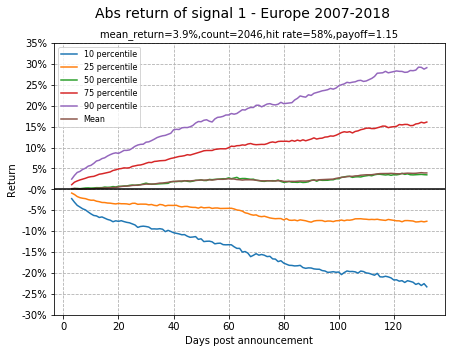

In [181]:
perf_chart_day(signal1_abs_df,"Days post announcement",
           "Return","Abs return of signal 1 - Europe 2007-2018",[7,5],
          [0.1,0.25,0.5,0.75,0.9])

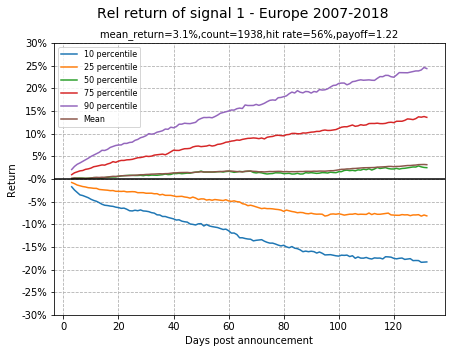

In [100]:
perf_chart_day(signal1_rel_df,"Days post announcement",
           "Return","Rel return of signal 1 - Europe 2007-2018",[7,5],
          [0.1,0.25,0.5,0.75,0.9])

## Plot by sectors (announcement day)

In [247]:
## sector mapping and unique sector list, add the sector column to the signal
def sector_mapping(ticker,mapping_df):
    mapping=mapping_df.dropna()
    if ticker in mapping.index:
        sector=mapping[ticker]
    else:
        sector=None
    return sector
    
unique_sector=list(set(data_dict_Europe["Property"]["Sector"].dropna().values))
signal1_with_sector=signal1.copy()
signal1_next_with_sector=signal1_next.copy()
signal1_with_sector["sector"]=[sector_mapping(i,data_dict_Europe["Property"]["Sector"]) for i in signal1_with_sector.index]
signal1_next_with_sector["sector"]=[sector_mapping(i,data_dict_Europe["Property"]["Sector"]) for i in signal1_next_with_sector.index]

In [ ]:
# plot the performance for different sectors
def plot_by_sector(sector_list,figsize,fontsize,title,signal1,signal1_next,abs_return,rel_return,holding_period,earning,entry):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize)
    for idx, sector in enumerate(sector_list):
        signal1_sector=signal1[signal1["sector"]==sector].iloc[:,:-1]
        signal1_next_sector=signal1_next[signal1_next["sector"]==sector].iloc[:,:-1]
        
        ax1=fig.add_subplot(len(sector_list),2,idx*2+1)
        abs_return_df=signal1_df_day(signal1_sector,signal1_next_sector,abs_return,holding_period,earning,entry)
        abs_cum_return=(1+abs_return_df.mean(axis=1)).cumprod()-1
        ax1.plot(abs_cum_return)
        ax1.set_title("Abs return in "+str(sector))
        count,hit, payoff=trading_analytics_day(abs_return_df)
        ax1.legend(['count='+str(count)+
                    ',hit rate='+str("{:.0%}".format(hit))+
                    ',payoff='+str(round(payoff,2))])

        ax2=fig.add_subplot(len(sector_list),2,idx*2+2)
        rel_return_df=signal1_df_day(signal1_sector,signal1_next_sector,rel_return,holding_period,earning,entry)
        rel_cum_return=(1+rel_return_df.mean(axis=1)).cumprod()-1
        ax2.plot(rel_cum_return)
        ax2.set_title("Rel return in "+str(sector))
        count,hit, payoff=trading_analytics_day(rel_return_df)
        ax2.legend(['count='+str(count)+
                    ',hit rate='+str("{:.0%}".format(hit))+
                    ',payoff='+str(round(payoff,2))])
    
    plt.show()

In [ ]:
plot_by_sector(unique_sector,(15,60),18,
             "Performance of signal 1 for Europe 2007-2018",signal1_with_sector,signal1_next_with_sector,abs_return_Europe,rel_return_Europe,120,True,3)

## Plot by countries (announcement day)

In [1095]:
## unique country list, add the country column to the signal
signal1_with_country=signal1.copy()
signal1_with_country["country"]=[i[-2:] for i in signal1_with_country.index]
signal1_next_with_country=signal1_next.copy()
signal1_next_with_country["country"]=[i[-2:] for i in signal1_next_with_country.index]

unique_country=list(set(signal1_with_country["country"]))

In [565]:
# plot the performance by countries
def plot_by_country(country_list,figsize,fontsize,title,signal1,signal1_next,abs_return,rel_return,holding_period,earning,entry):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize)
    for idx, country in enumerate(country_list):
        signal1_country=signal1[signal1["country"]==country].iloc[:,:-1]
        signal1_next_country=signal1_next[signal1_next["country"]==country].iloc[:,:-1]
        
        ax1=fig.add_subplot(len(country_list),2,idx*2+1)
        #print(signal1_country,signal1_next_country)
        abs_return_df=signal1_df_day(signal1_country,signal1_next_country,abs_return,holding_period,earning,entry)
        if abs_return_df is not None:
            abs_cum_return=(1+abs_return_df.mean(axis=1)).cumprod()-1
            ax1.plot(abs_cum_return)
            ax1.set_title("Abs return in "+str(country))
            count,hit, payoff=trading_analytics_day(abs_return_df)
            ax1.legend(['count='+str(count)+
                        ',hit rate='+str("{:.0%}".format(hit))+
                        ',payoff='+str(round(payoff,2))])
        else:
            pass
        
        ax2=fig.add_subplot(len(country_list),2,idx*2+2)
        rel_return_df=signal1_df_day(signal1_country,signal1_next_country,rel_return,holding_period,earning,entry)
        if rel_return_df is not None:  
            rel_cum_return=(1+rel_return_df.mean(axis=1)).cumprod()-1
            ax2.plot(rel_cum_return)
            ax2.set_title("Rel return in "+str(country))
            count,hit, payoff=trading_analytics_day(rel_return_df)
            ax2.legend(['count='+str(count)+
                        ',hit rate='+str("{:.0%}".format(hit))+
                        ',payoff='+str(round(payoff,2))])
        else:
            pass
    plt.show()

In [ ]:
plot_by_country(unique_country,(15,50),18,
             "Performance of signal 1 for Europe 2007-2018",signal1_with_country,signal1_next_with_country,abs_return_Europe,rel_return_Europe,120,True,3)

# Signal result by actual date - account curve

In [22]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#;use actual dates rather than number of days post announcement
def signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]
        if (s[1] in return_series.index):
            if not np.isnan(return_series.loc[s[1]]): 
                day0=return_series.index.tolist().index(s[1]) #index of day 0
                if s[2] is None:
                    period=holding
                elif earning is False:
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y"))-entry)
                elif (signal is False) & (s[3] is not None):
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[3],"%d/%b/%Y"))-entry)
                else:
                    period=holding
                target_series=return_series.iloc[day0+entry:day0+min(period+entry, len(return_series[day0:]))].dropna() # different from return_dict with number of dates post announcement
                target_series.name=(s[0])
                signal1_dict[s]=target_series
            else:
                pass
        else:
            pass          
    return signal1_dict

In [23]:
## signal df function adjusted to the actual dates
def signal1_df_date(date_df,return_for_signal,return_df,EAR_low,EAR_high,revision_df,revision_low,revision_high,holding,earning,signal,entry):
    signal1,signal1_next=signal1_formation(date_df,return_for_signal,entry,EAR_low,EAR_high,revision_df,revision_low,revision_high)
    signal1_list=signal1_stacking(signal1,signal1_next)
    signal1_dict=signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry)
    return_list=[]
    for i,v in signal1_dict.items():
        return_list.append(v)
    my_df=pd.concat(return_list,axis=1)
    my_df.columns=list(signal1_dict.keys())
    my_df.index=[datetime.strptime(x,"%d/%b/%Y") for x in my_df.index.tolist()]
    signal1_df=my_df.sort_index()
    return signal1_df

In [97]:
# singal1 dataframe by actual date Europe
signal1_rel_df_date_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,1000,data_dict_Europe['Revision'],0.02,1000,120,False,False,2)
signal1_abs_df_date_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,abs_return_Europe,2,1000,data_dict_Europe['Revision'],0.02,1000,120,False,False,2)

In [98]:
# singal1 dataframe by actual date US
signal1_rel_df_date_US=signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,2,1000,data_dict_US['Revision'],0.05,1000,120,False,False,2)
signal1_abs_df_date_US=signal1_df_date(data_dict_US['Date'],rel_return_US,abs_return_US,2,1000,data_dict_US['Revision'],0.05,1000,120,False,False,2)

In [143]:
# concatnate two dataframes to a global version
signal1_rel_df_date_global=pd.concat([signal1_rel_df_date_Europe,signal1_rel_df_date_US],axis=1)
signal1_abs_df_date_global=pd.concat([signal1_abs_df_date_Europe,signal1_abs_df_date_US],axis=1)

In [139]:
## grab volume data
volume_Europe=data_dict_Europe["Volume"]
volume_US=data_dict_US["Volume"]

## function to grab volume
def get_volume(signal_tuple,volume_df,date_df):
    ticker=signal_tuple[0]
    date_series=date_df.loc[ticker]
    volume_series=volume_df.loc[ticker]
    timestamp=pd.Timestamp(datetime.strptime(signal_tuple[1],"%d/%b/%Y").year,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").month,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").day)
    location=date_series.tolist().index(timestamp)
    return volume_series.iloc[location]

In [28]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal1_account(signal_df_date,average_gross,capital,volume_df,date_df,liquidity_constraint):
    average_number=signal_df_date.count(axis=1).mean()
    avg_size=average_gross/100/average_number
    size_row=signal_df_date.apply(lambda x: min(avg_size,get_volume(x.name,volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count=signal_df_date.copy()
    count[(count>=0)|(count<0)]=1.0
    gross=(count*size_row).sum(axis=1)
    gross=gross[gross!=0]
    account_curve=(((signal_df_date+1).cumprod()-1)*size_row).ffill().sum(axis=1)
    ind_return=((signal_df_date+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs((count*size_row).fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    return account_curve,avg_size,gross,ind_return,turnover

## Performance plot by actual date

In [29]:
# Performance analytics
# 1. trading analytics
def trading_analytics_date(signal_account):
    ind_return=signal_account[3]
    signal_count=len(ind_return)
    account_curve=signal_account[0]
    
    if signal_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        
        account_price=account_curve+1
        ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
        ann_ret=np.mean(account_price.diff()/account_price.shift(1))*260
        ann_sharpe=ann_ret/ann_vol
        
        low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
        high_date=account_curve[:low_date].idxmax()
        max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])
        
        return signal_count,hit_rate,payoff_ratio,ann_ret,ann_vol,ann_sharpe,max_dd

In [30]:
# 2. aggregate abs/rel performance over time
def plot_account_curve(signal_account,xlabel,title,figsize):
    account_curve,avg_size,gross,ind_return,turnover=signal_account
    
    fig=plt.figure(figsize=figsize)
    ax1=fig.add_subplot(1,1,1)
    ln1=ax1.plot(account_curve,label='signal',color='b')

    
    val1=ax1.get_yticks()
    start=val1[0]
    end=val1[-1]
    ax1.set_yticks(np.arange(start,end,0.1))  
    adj_val1=ax1.get_yticks()
    ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
    
    ax2=ax1.twinx()
    ln2=ax2.plot(gross,label='long-gross',color='silver')

    val2=ax2.get_yticks()
    start=val2[0]
    end=val2[-1]
    ax2.set_yticks(np.arange(start,end,0.1))  
    adj_val2=ax2.get_yticks()
    ax2.set_yticklabels(["{:.0%}".format(x) for x in adj_val2])
    
    count,hit,payoff,ret,vol,sharpe,max_dd=trading_analytics_date(signal_account)
    
    plt.title("\n".join(wrap('count='+str(count)+
                             ',avg_size='+str("{:.1%}".format(avg_size))+
                             ',hit_rate='+str("{:.0%}".format(hit))+
                             ',payoff='+str(round(payoff,1))+
                             ',return='+str("{:.1%}".format(ret))+
                             ',vol='+str("{:.1%}".format(vol))+
                             ',sharpe='+str(round(sharpe,1))+
                             ',turnover='+str(round(turnover,1))+'x'+                             
                             ',max_drawdown='+str("{:.1%}".format(max_dd)))),fontsize=10)
 
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Return')
    ax2.set_ylabel('Gross')
    plt.suptitle(title,y=1.05,fontsize=16)
    plt.grid(linestyle='dashed')
    plt.legend(ln1+ln2,[l.get_label() for l in ln1+ln2])
    ax1.axhline(y=0,color='k')

    plt.show()


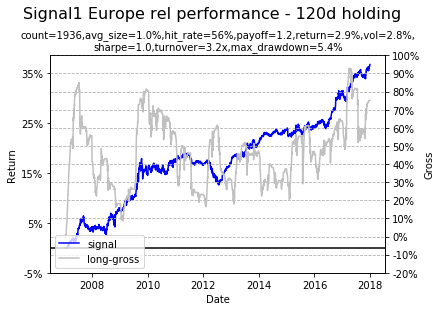

In [101]:
plot_account_curve(signal1_account(signal1_rel_df_date_Europe,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe rel performance - 120d holding",[6,4])

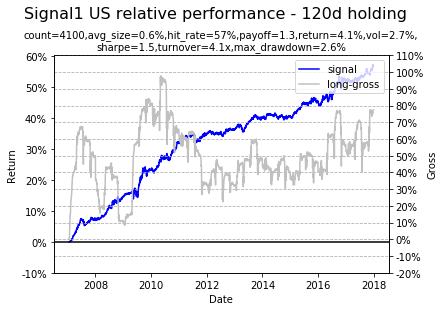

In [102]:
plot_account_curve(signal1_account(signal1_rel_df_date_US,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US relative performance - 120d holding",[6,4])

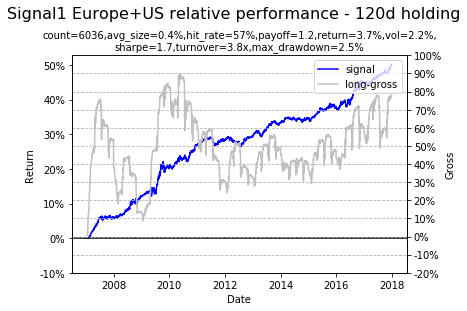

In [165]:
plot_account_curve(signal1_account(signal1_rel_df_date_global,50,100,data_dict_global["Volume"],data_dict_global["Date"],0.1),
                   "Date","Signal1 Europe+US relative performance - 120d holding",[6,4])

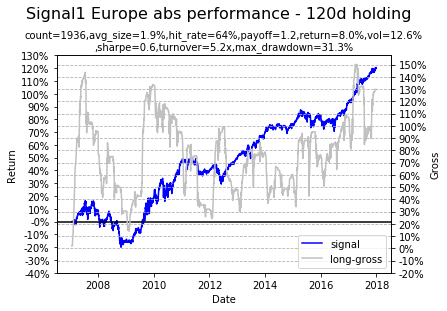

In [107]:
plot_account_curve(signal1_account(signal1_abs_df_date_Europe,100,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe abs performance - 120d holding",[6,4])

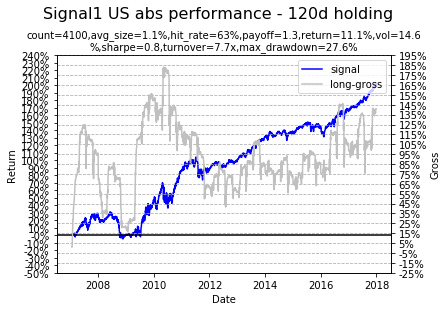

In [108]:
plot_account_curve(signal1_account(signal1_abs_df_date_US,100,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US abs performance - 120d holding",[6,4])

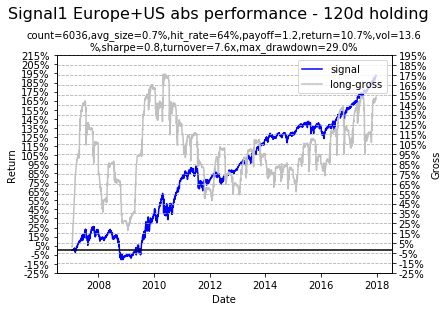

In [154]:
plot_account_curve(signal1_account(signal1_abs_df_date_global,100,100,data_dict_global["Volume"],data_dict_global["Date"],0.1),
                   "Date","Signal1 Europe+US abs performance - 120d holding",[6,4])

## Account curve by sectors

In [69]:
## sector mapping and unique sector list, add the sector column to the signal
def sector_mapping(ticker,mapping_df):
    mapping=mapping_df.dropna()
    if ticker in mapping.index:
        sector=mapping[ticker]
    else:
        sector=None
    return sector

In [70]:
# plot the performance for different sectors
def plot_account_curve_by_sector(sector_df,figsize,fontsize,title,signal_rel_df_date,gross,capital,volume_df,date_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.89)
    sector_list=list(set(sector_df.dropna().values))
    sector_row=signal_rel_df_date.apply(lambda x: sector_mapping(x.name[0],sector_df),axis=0)
    
    for idx, sector in enumerate(sector_list):
        signal_rel_df_date_sector=signal_rel_df_date.loc[:,sector_row==sector]
                
        ax1=fig.add_subplot(len(sector_list),2,idx+1)
        account=signal1_account(signal_rel_df_date_sector,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title(str(sector))
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                   #',hit_rate='+str("{:.0%}".format(hit))+
                                   #',payoff='+str(round(payoff,2))+
                                   #',avg_size='+str("{:.1%}".format(account[1]))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))
                                 #',sharpe='+str(round(sharpe,1))+
                                 #',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    


    
    plt.show()

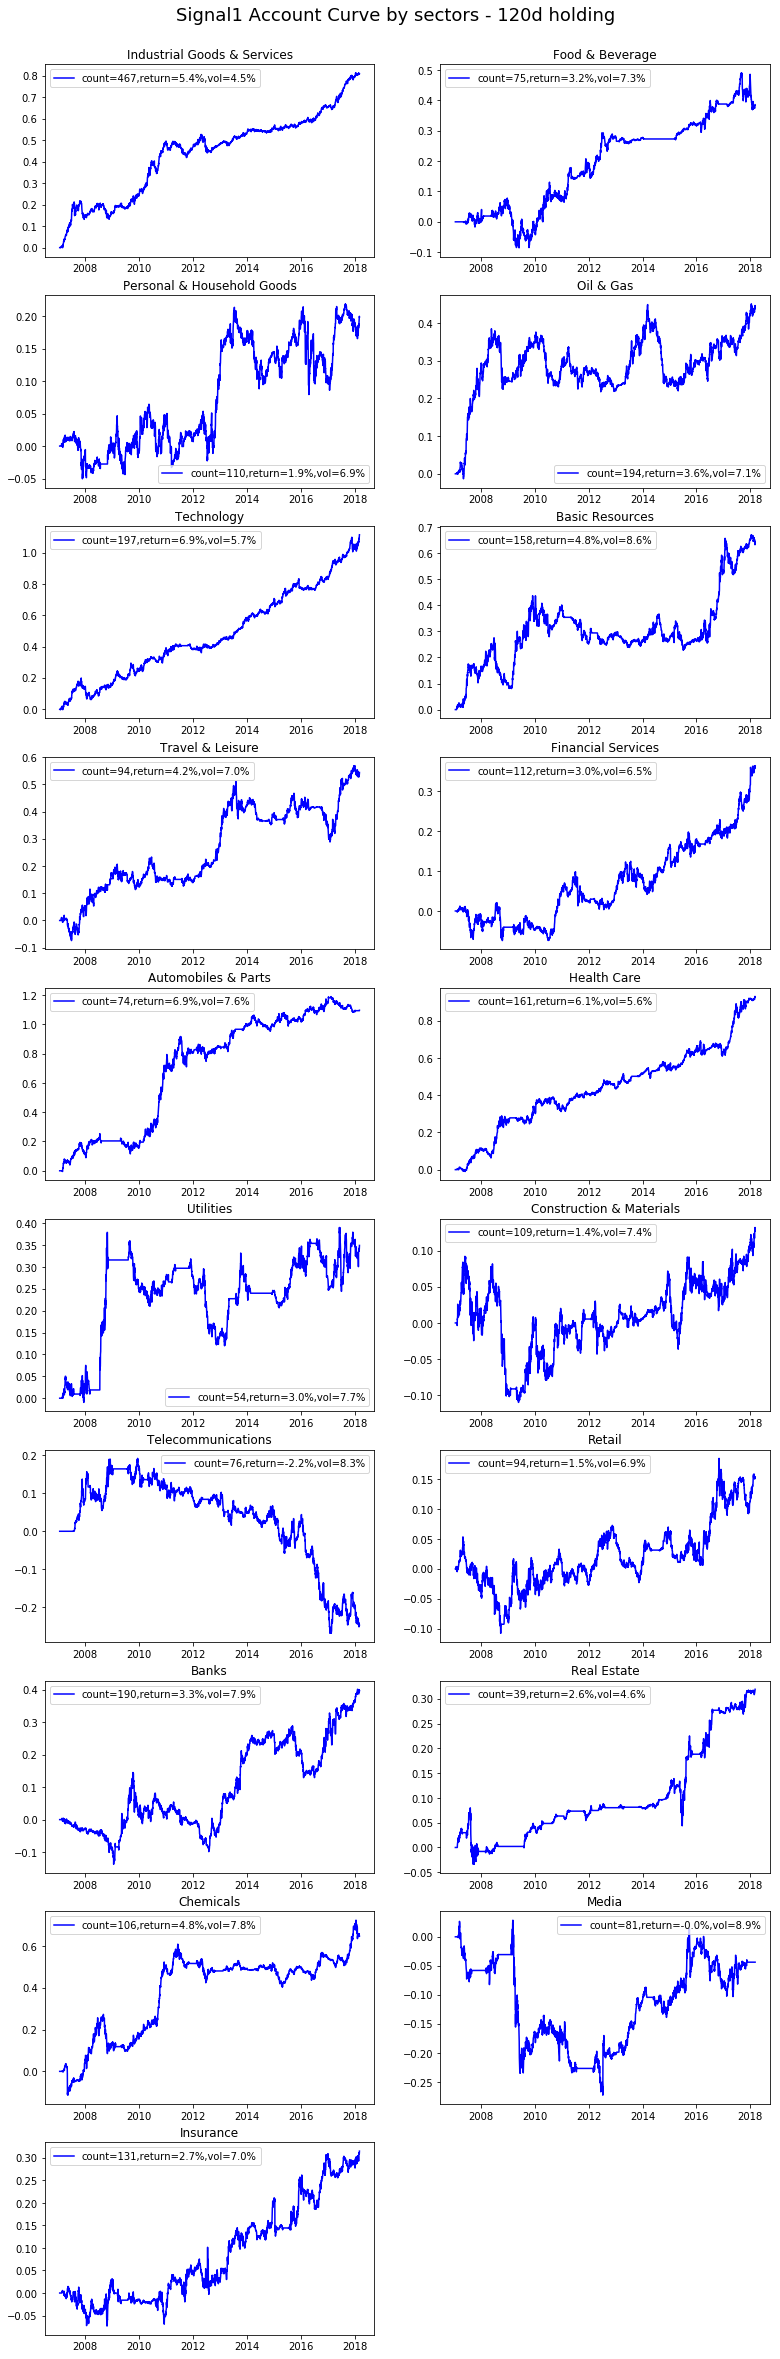

In [71]:
plot_account_curve_by_sector(data_dict_Europe["Property"]["Sector"],(13,80),18,
                            "Signal1 Account Curve by sectors - 120d holding",signal1_rel_df_date,
                            50,5,volume,data_dict_Europe["Date"],0.1)

## Account curve by countries

In [72]:
# plot the performance for different sectors
def plot_account_curve_by_country(figsize,fontsize,title,signal_rel_df_date,gross,capital,volume_df,date_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.89)
    country_row=signal_rel_df_date.apply(lambda x: x.name[0][-2:],axis=0)
    country_list=list(set(country_row.dropna().values))      
    
    for idx, country in enumerate(country_list):
        signal_rel_df_date_country=signal_rel_df_date.loc[:,country_row==country]
                
        ax1=fig.add_subplot(len(country_list),2,idx+1)
        account=signal1_account(signal_rel_df_date_country,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title(str(country))
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                   #',hit_rate='+str("{:.0%}".format(hit))+
                                   #',payoff='+str(round(payoff,2))+
                                   #',avg_size='+str("{:.1%}".format(account[1]))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))
                                 #',sharpe='+str(round(sharpe,1))+
                                 #',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    
    
  
    
    plt.show()

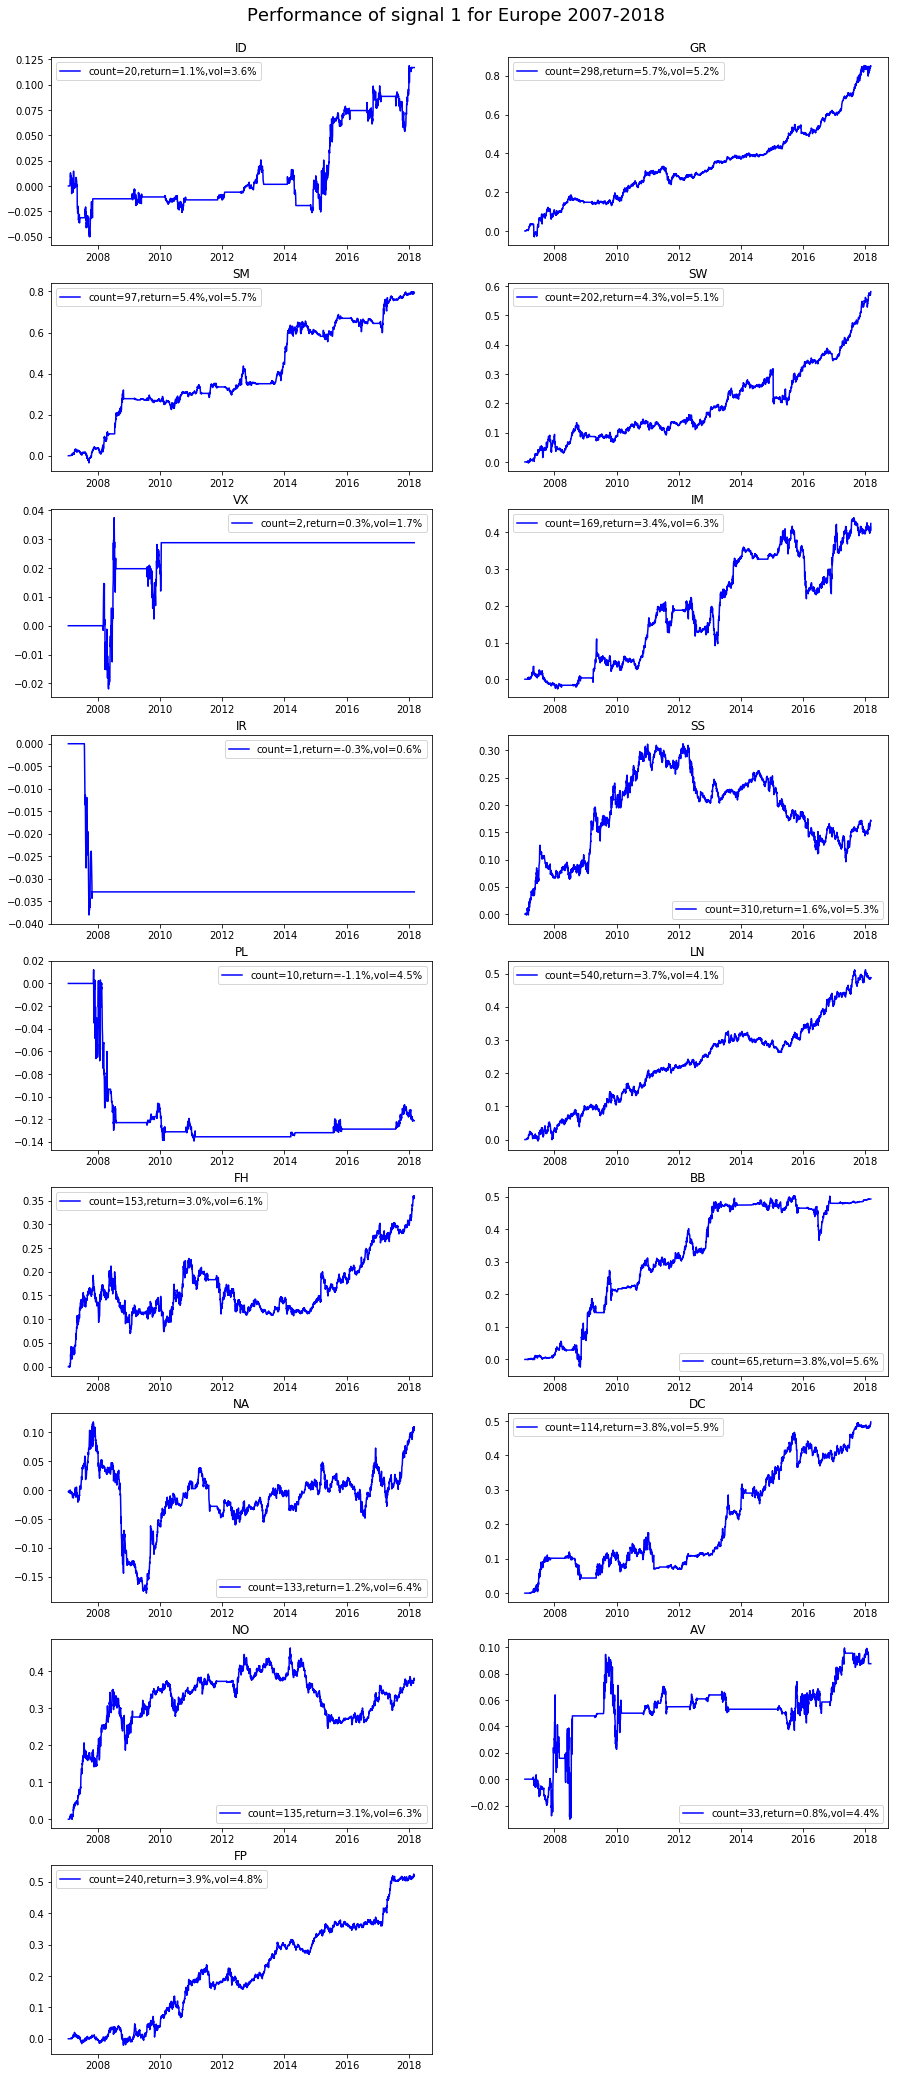

In [73]:
plot_account_curve_by_country((15,70),18,
                            "Performance of signal 1 for Europe 2007-2018",signal1_rel_df_date,
                            50,10,volume,data_dict_Europe["Date"],0.1)

## Account curve by size

In [252]:
## function to grab market cap
def get_market_cap(signal_tuple,market_cap_df,date_df):
    ticker=signal_tuple[0]
    date_series=date_df.loc[ticker]
    cap_series=market_cap_df.loc[ticker]
    timestamp=pd.Timestamp(datetime.strptime(signal_tuple[1],"%d/%b/%Y").year,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").month,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").day)
    location=date_series.tolist().index(timestamp)
    return cap_series.iloc[location]

In [263]:
# plot the performance for different sizes
def plot_account_curve_by_size(quantile_list,figsize,fontsize,title,signal1_df_date,gross,capital,volume_df,date_df,size_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.93)
    size_row_date=signal1_df_date.apply(lambda x: get_market_cap(x.name,size_df,date_df),axis=0)
    quantile_value=size_row_date.quantile(quantile_list).values.tolist()
    
    for idx in range(len(quantile_value)-1):
        signal_df_date_size=signal1_df_date.loc[:,(size_row_date>=quantile_value[idx])&(size_row_date<=quantile_value[idx+1])]                             
        
        ax1=fig.add_subplot(len(quantile_list)+1,1,idx+1)      
        account=signal1_account(signal_df_date_size,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title("Account Curve by market cap "+str(round(quantile_value[idx],1))+" - "+str(round(quantile_value[idx+1],1)))
    
        val1=ax1.get_yticks()
        start=val1[0]
        end=val1[-1]
        ax1.set_yticks(np.arange(start,end,0.1))  
        adj_val1=ax1.get_yticks()
        ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
        
        ax1.grid(linestyle='dashed')
        ax1.axhline(y=0,color='k')
            
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                    ',avg_size='+str("{:.1%}".format(account[1]))+
                                #',hit_rate='+str("{:.0%}".format(hit))+
                                 #',payoff='+str(round(payoff,1))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))+
                                 ',sharpe='+str(round(sharpe,1))+
                                 ',turnover='+str(round(account[4],1))+'x'+      
                                 ',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    
    
    plt.show()

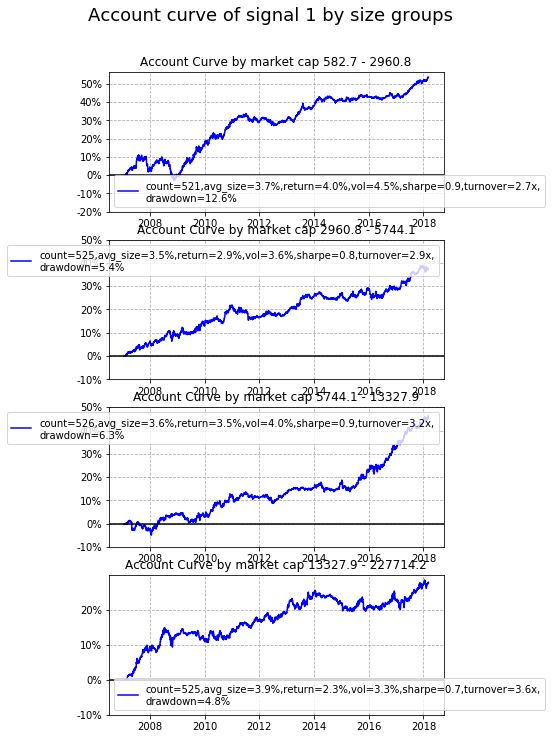

In [115]:
plot_account_curve_by_size([0,0.25,0.5,0.75,1],(6,18),18,
                            "Account curve of signal 1 by size groups",signal1_rel_df_date,
                            50,30,volume,data_dict_Europe["Date"],market_cap,0.1)

## Account curve by PE

In [1009]:
## grab market cap data
PE=data_dict_Europe["PE"]

## function to grab market cap
def get_PE(signal_tuple, PE_df,date_df):
    ticker=signal_tuple[0]
    date_series=date_df.loc[ticker]
    PE_series=PE_df.loc[ticker]
    timestamp=pd.Timestamp(datetime.strptime(signal_tuple[1],"%d/%b/%Y").year,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").month,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").day)
    location=date_series.tolist().index(timestamp)
    return PE_series.iloc[location]

In [1050]:
# plot the performance for different PE
def plot_account_curve_by_PE(quantile_list,figsize,fontsize,title,signal1_df_date,gross,capital,volume_df,date_df,PE_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.93)
    PE_row_date=signal1_df_date.apply(lambda x: get_PE(x.name,PE_df,date_df),axis=0)
    quantile_value=PE_row_date.quantile(quantile_list).values.tolist()
    
    for idx in range(len(quantile_value)-1):
        signal_df_date_PE=signal1_df_date.loc[:,(PE_row_date>=quantile_value[idx])&(PE_row_date<=quantile_value[idx+1])]            
        
        ax1=fig.add_subplot(len(quantile_list)+1,1,idx+1)      
        account=signal1_account(signal_df_date_PE,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title("Account Curve by PE "+str(round(quantile_value[idx],1))+" - "+str(round(quantile_value[idx+1],1)))
    
        val1=ax1.get_yticks()
        start=val1[0]
        end=val1[-1]
        ax1.set_yticks(np.arange(start,end,0.1))  
        adj_val1=ax1.get_yticks()
        ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
        
        ax1.grid(linestyle='dashed')
        ax1.axhline(y=0,color='k')
            
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                    ',avg_size='+str("{:.1%}".format(account[1]))+
                                #',hit_rate='+str("{:.0%}".format(hit))+
                                 #',payoff='+str(round(payoff,1))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))+
                                 ',sharpe='+str(round(sharpe,1))+
                                 ',turnover='+str(round(account[4],1))+'x'+      
                                 ',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    
    
    plt.show()

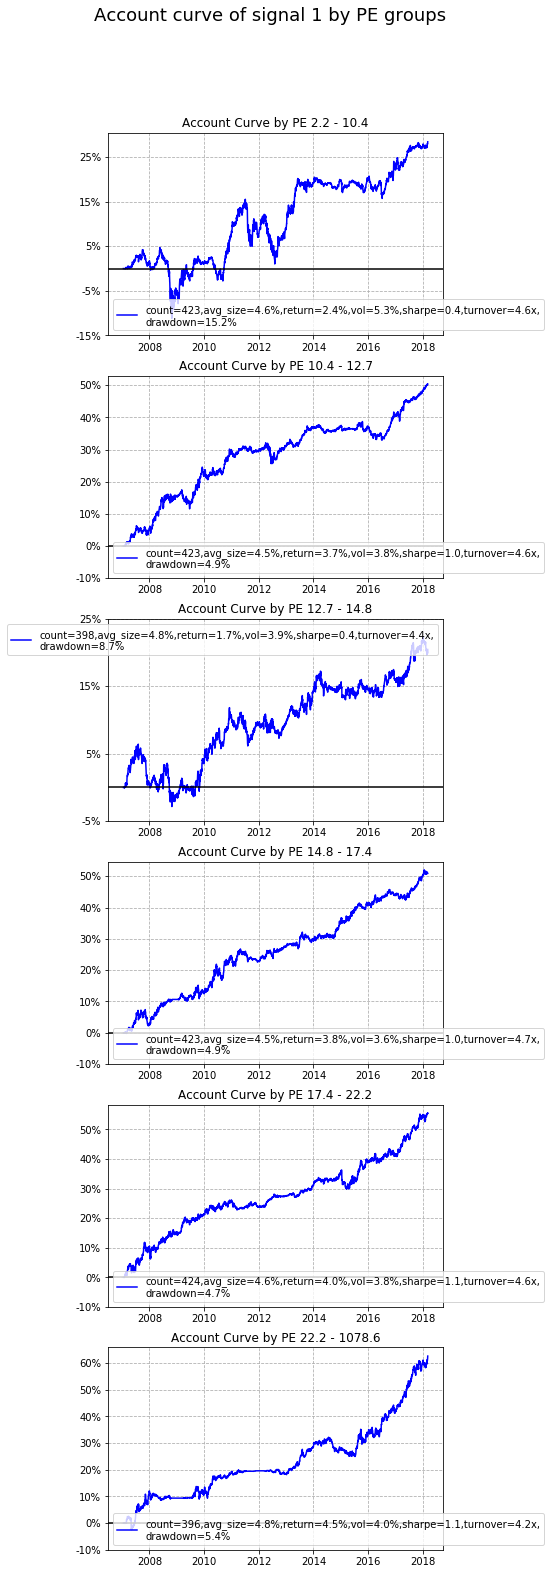

In [1055]:
plot_account_curve_by_PE([0,0.17,0.34,0.5,0.67,0.84,1],(6,35),18,
                            "Account curve of signal 1 by PE groups",signal1_rel_df_date,
                            50,20,volume,data_dict_Europe["Date"],PE,0.1)

## Account curve by different holding periods

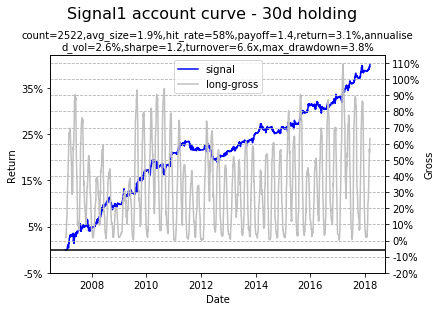

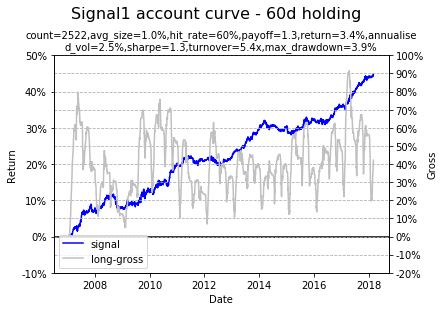

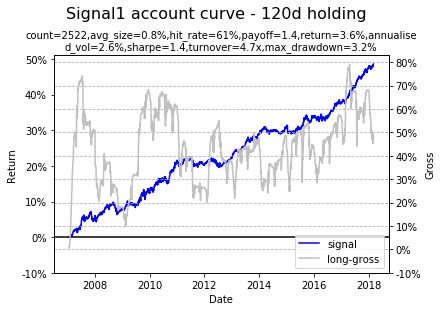

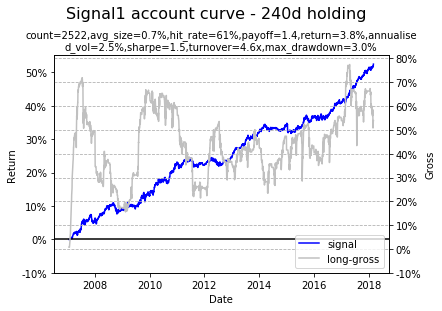

In [836]:
plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,30,False,False,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                                   "Date","Signal1 account curve - 30d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,60,False,False,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                                   "Date","Signal1 account curve - 60d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,120,False,False,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                                   "Date","Signal1 account curve - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,240,False,False,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                                   "Date","Signal1 account curve - 240d holding",[6,4])

## Account curve by entry point

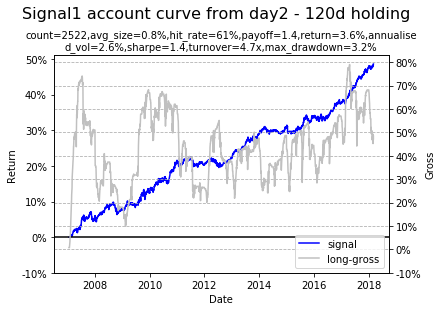

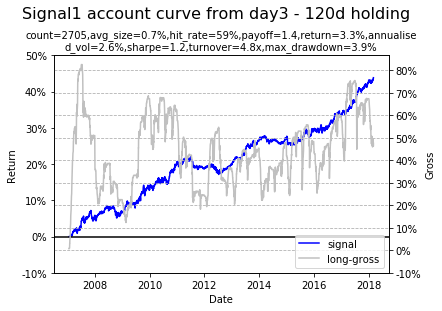

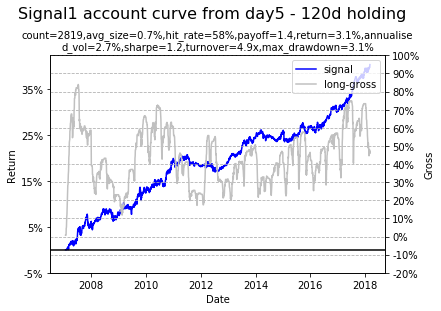

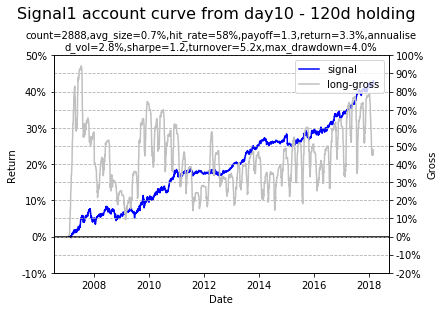

In [840]:
plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,120,False,False,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,120,False,False,3)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day3 - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,120,False,False,5)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day5 - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,120,False,False,10)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day10 - 120d holding",[6,4])

## Account curve with stop loss

In [875]:
## utility function to get the vol from a column of signal_df
def signal1_vol(signal_column,return_df,vol_lookback):
    signal_tuple=signal_column.name
    signal_series=abs_return.loc[signal_tuple[0]]
    location=signal_series.index.tolist().index(signal_tuple[1])
    vol_range=min(vol_lookback,len(signal_series[:location]))
    signal_vol=signal_series[location-vol_range-1:location].std()
    return signal_vol

In [876]:
# signal_df post stop loss filter 
def signal1_filter_stop(signal_df,stop_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

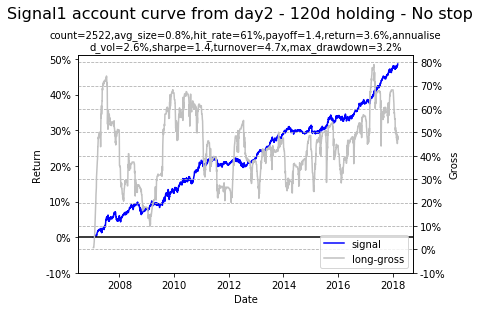

In [877]:
plot_account_curve(signal1_account(signal1_rel_df_date
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - No stop",[6,4])

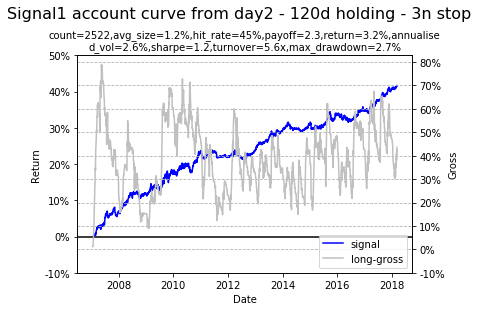

In [878]:
plot_account_curve(signal1_account(signal1_filter_stop(signal1_rel_df_date,3,rel_return_Europe,30)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 3n stop",[6,4])

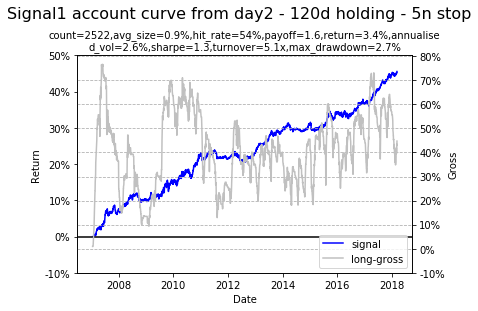

In [879]:
plot_account_curve(signal1_account(signal1_filter_stop(signal1_rel_df_date,5,rel_return,30)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 5n stop",[6,4])

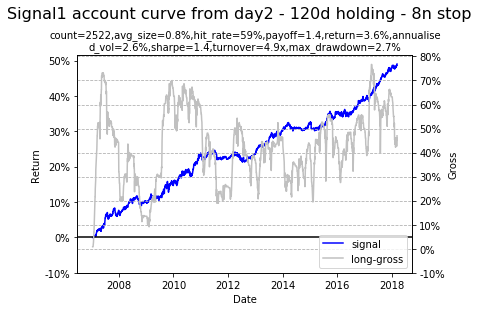

In [880]:
plot_account_curve(signal1_account(signal1_filter_stop(signal1_rel_df_date,8,rel_return_Europe,30)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 8n stop",[6,4])

## Account curve with drawdown stop

In [214]:
# signal_df post stop loss filter 
def signal1_filter_dd(signal_df,dd_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    acct=(1+signal_df).cumprod()-1
    signal_dd=(acct.cummax(axis=0)-acct).expanding(min_periods=1).max()/vol_row
    signal_filter_dd=signal_df[-(signal_dd.shift(1,axis=0)>dd_level)]
    return signal_filter_dd

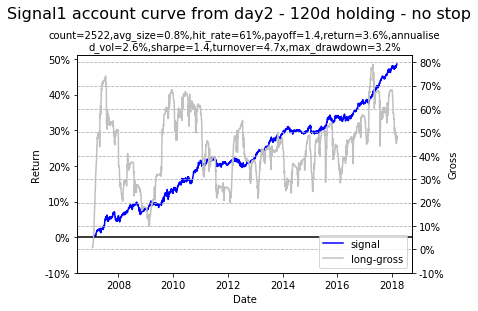

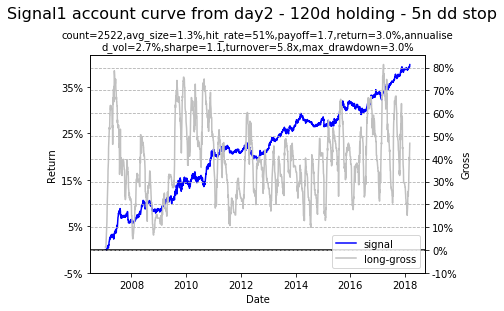

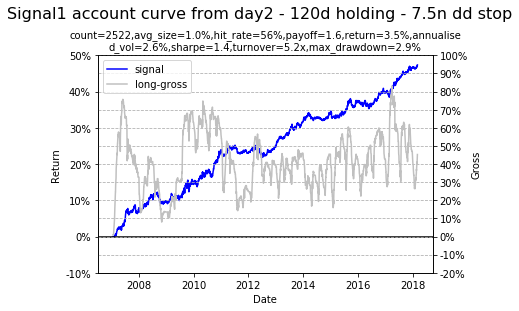

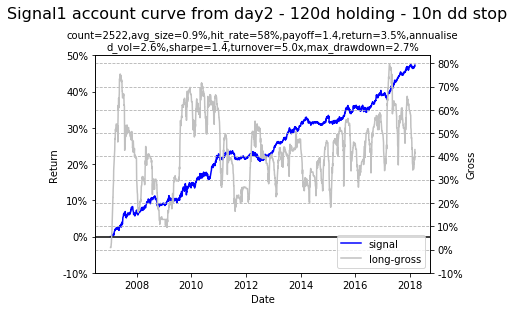

In [881]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - no stop",[6,4])

plot_account_curve(signal1_account(signal1_filter_dd(signal1_rel_df_date,5,rel_return_Europe,30)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 5n dd stop",[6,4])

plot_account_curve(signal1_account(signal1_filter_dd(signal1_rel_df_date,7.5,rel_return_Europe,30)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 7.5n dd stop",[6,4])

plot_account_curve(signal1_account(signal1_filter_dd(signal1_rel_df_date,10,rel_return_Europe,30)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 10n dd stop",[6,4])

## Account curve with moving average

In [882]:
## filter signal_df with moving average
def signal1_filter_MA(signal_df,price_df,MA_lookback):
    MA=(price_df.rolling(MA_lookback,axis=1).mean()<price_df)|(price_df.shift(1).rolling(MA_lookback,axis=1).mean()<price_df.shift(1))
    MA_evaluate=signal_df.apply(lambda x: MA.loc[x.name[0]].loc[x.name[1]])
    signal_filter_MA=signal_df.loc[:,MA_evaluate]
    return signal_filter_MA

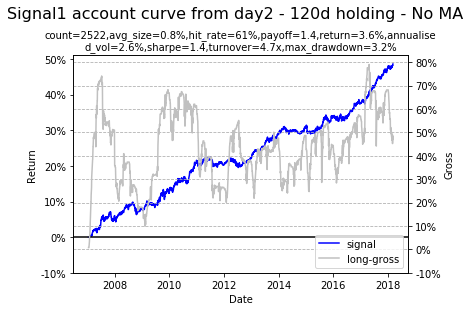

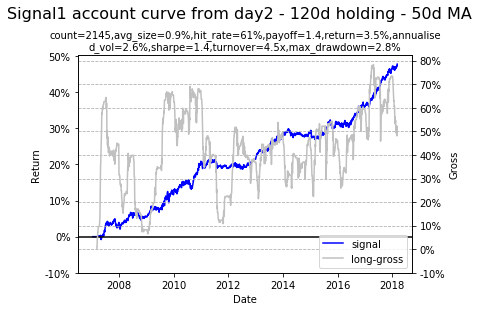

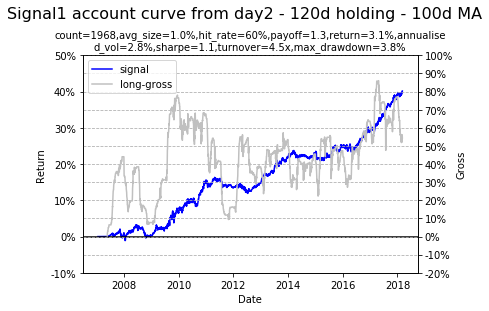

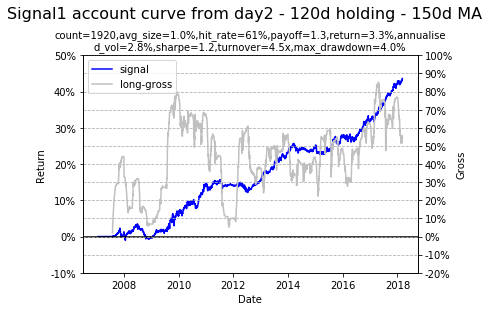

In [883]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - No MA",[6,4])

plot_account_curve(signal1_account(signal1_filter_MA(signal1_rel_df_date,price_Europe,50)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 50d MA",[6,4])

plot_account_curve(signal1_account(signal1_filter_MA(signal1_rel_df_date,price_Europe,100)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 100d MA",[6,4])

plot_account_curve(signal1_account(signal1_filter_MA(signal1_rel_df_date,price_Europe,150)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 150d MA",[6,4])

## Account curve with abs/rel high

In [216]:
## filter signal_df with abs/rel high
def signal1_filter_high(signal_df,price_df,rolling_window):
    high_df=price_df.rolling(window=rolling_window,axis=1).max()==price_df
    high_evaluate=signal_df.apply(lambda x: (high_df.loc[x.name[0]].loc[x.name[1]]) or
                                  high_df.loc[x.name[0]].iloc[high_df.loc[x.name[0]].index.tolist().index(x.name[1])+1]) # either day 1 or day 2
    signal_filter_high=signal_df.loc[:,high_evaluate]
    return signal_filter_high

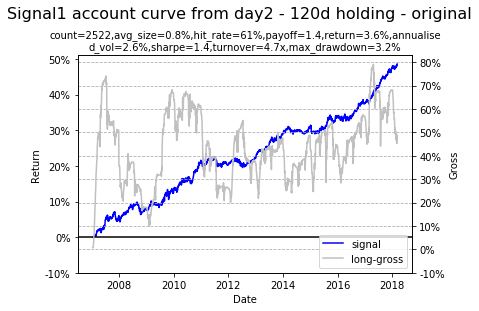

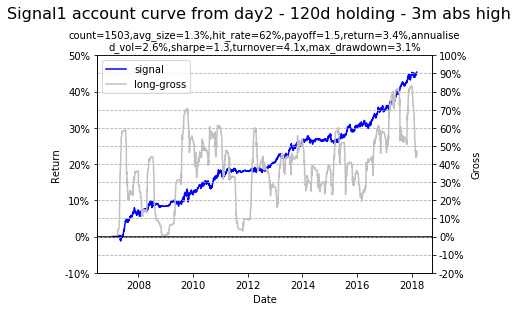

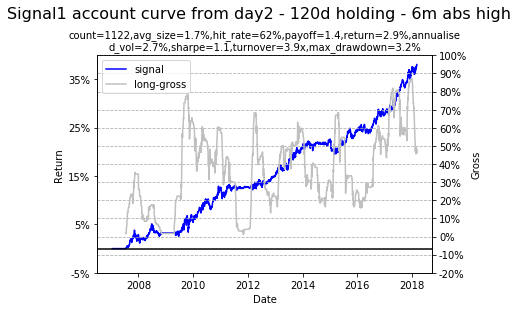

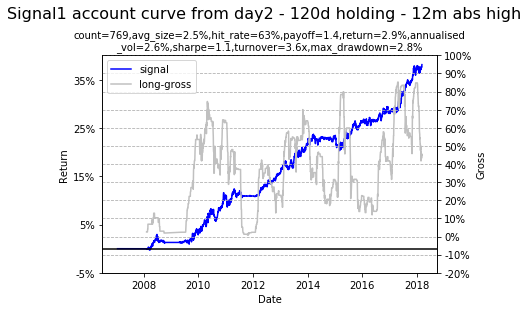

In [884]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - original",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,price_Europe,60)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 3m abs high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,price_Europe,120)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 6m abs high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,price_Europe,240)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 12m abs high",[6,4])

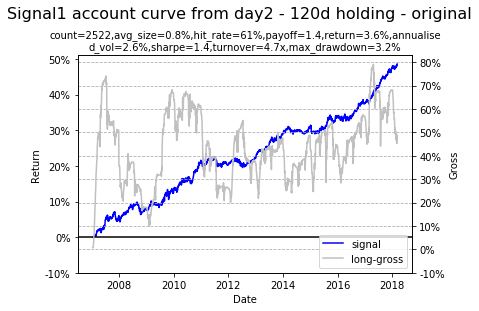

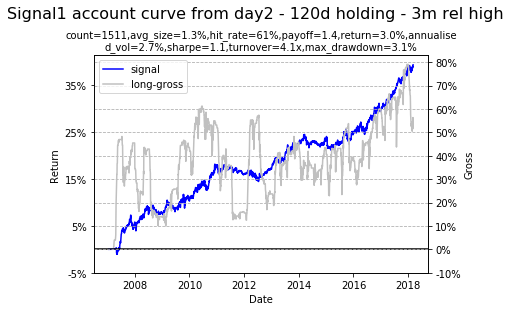

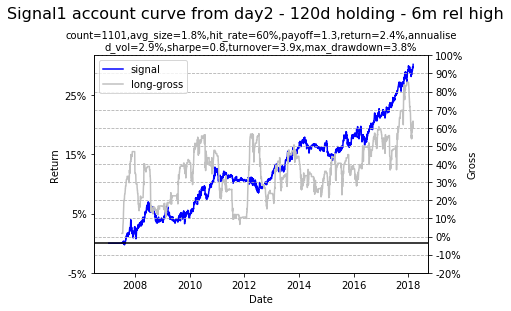

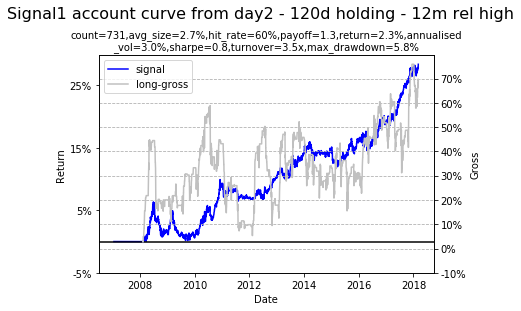

In [885]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - original",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,rel_price_Europe,60)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 3m rel high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,rel_price_Europe,120)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 6m rel high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,rel_price_Europe,240)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 12m rel high",[6,4])

## Stress test the base case by altering earning upgrade and price move up

In [726]:
# get the revision and EAR quantile
revision_list=data_dict_Europe['Revision'].unstack(level=-1).dropna()
revision_quantile=revision_list.quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).tolist()
EAR_full=EAR_df(data_dict_Europe["Date"],rel_return_Europe,2,30).fillna(0.0).reindex(data_dict_Europe['Revision'].index.tolist())
EAR_list=EAR_full.unstack(level=-1)[EAR_full.unstack(level=-1)!=0]
EAR_quantile=EAR_list.quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).tolist()

In [730]:
# build the monster dictionary of different scenarios of base signal, this is gonna take an hour!!!!!!!!!!!!!
EAR_upgrade_dict={}

for idx in range(len(EAR_quantile)-1):
    for i in range(len(revision_quantile)-1):
        EAR_upgrade_dict[("Move "+str(round(EAR_quantile[idx],1))+str(" to ")+str(round(EAR_quantile[idx+1],1)),
                          "Upgrade "+str("{:.1%}".format(revision_quantile[i]))+str(" to ")+str("{:.1%}".format(revision_quantile[i+1])))]=trading_analytics_date(signal1_account(
                                    signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,EAR_quantile[idx],EAR_quantile[idx+1],data_dict['Revision'],revision_quantile[i],revision_quantile[i+1],120,True,True,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1))

In [735]:
# Build a dummy dataframe with the relevant column and index names
EAR_upgrade_df=pd.DataFrame(np.zeros((10,10)),
                  columns=["Upgrade "+str("{:.1%}".format(revision_quantile[i]))+str(" to ")+str("{:.1%}".format(revision_quantile[i+1])) for i in range(len(revision_quantile)-1)],
                  index=["Move "+str(round(EAR_quantile[i],1))+str(" to ")+str(round(EAR_quantile[i+1],1)) for i in range(len(EAR_quantile)-1)])

In [770]:
# fill in relevant sharpe data
EAR_upgrade_sharpe=EAR_upgrade_df.copy()
for i,ival in enumerate(EAR_upgrade_sharpe.index.tolist()):
    for j,jval in enumerate(EAR_upgrade_sharpe.columns.tolist()):
        EAR_upgrade_sharpe.iloc[i,j]=round(EAR_upgrade_dict[(ival,jval)][5],2)

In [788]:
# fill in relevant return data
EAR_upgrade_ret=EAR_upgrade_df.copy()
for i,ival in enumerate(EAR_upgrade_ret.index.tolist()):
    for j,jval in enumerate(EAR_upgrade_ret.columns.tolist()):
        EAR_upgrade_ret.iloc[i,j]=round(EAR_upgrade_dict[(ival,jval)][3],3)

## Market correlation

In [155]:
# Signal account curve
account_rel_Europe=signal1_account(signal1_rel_df_date_Europe,50,100,volume,data_dict_Europe["Date"],0.1)[0]
account_rel_Europe.name="Signal1 Europe rel"
account_abs_Europe=signal1_account(signal1_abs_df_date_Europe,100,100,volume,data_dict_Europe["Date"],0.1)[0]
account_abs_Europe.name="Signal1 Europe abs"
account_rel_US=signal1_account(signal1_rel_df_date_US,50,100,volume_US,data_dict_US["Date"],0.1)[0]
account_rel_US.name="Signal1 US rel"
account_abs_US=signal1_account(signal1_abs_df_date_US,100,100,volume_US,data_dict_US["Date"],0.1)[0]
account_abs_US.name="Signal1 US abs"
account_rel_global=signal1_account(signal1_rel_df_date_global,50,100,data_dict_global["Volume"],data_dict_global["Date"],0.1)[0]
account_rel_global.name="Signal1 US+Europe rel"
account_abs_global=signal1_account(signal1_rel_df_date_global,100,100,data_dict_global["Volume"],data_dict_global["Date"],0.1)[0]
account_abs_global.name="Signal1 US+Europe abs"

In [156]:
account_df=pd.concat([account_rel_Europe,account_abs_Europe,account_rel_US,account_abs_US,
                     account_rel_global,account_abs_global],axis=1)

In [157]:
# Market
account_SXXP=(1+abs_return_Europe.loc["SXXP Index"]).cumprod()-1
account_momentum_Europe=(1+abs_return_Europe.loc["GSRPEMEL Index"]).cumprod()-1
account_momentum_US=(1+abs_return_US.loc["GSRPEMUL Index"]).cumprod()-1
account_SPX=(1+abs_return_US.loc["SPX Index"]).cumprod()-1
index_df=pd.concat([account_SXXP,account_momentum_Europe,account_momentum_US,account_SPX],axis=1)
index_df=index_df.reindex([datetime.strptime(x,"%d/%b/%Y") for x in index_df.index]).sort_index()

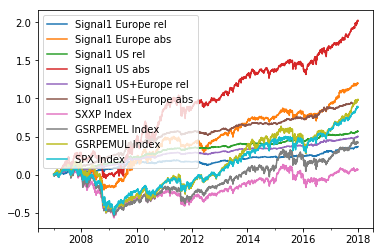

In [158]:
# Add them together and plot
account_combined=pd.concat([account_df,index_df],axis=1)
account_combined.plot()

In [159]:
# Correlation matrix
account_combined.corr()

,Signal1 Europe rel,Signal1 Europe abs,Signal1 US rel,Signal1 US abs,Signal1 US+Europe rel,Signal1 US+Europe abs,SXXP Index,GSRPEMEL Index,GSRPEMUL Index,SPX Index
Signal1 Europe rel,1.000000,0.942117,0.966523,0.942105,0.981844,0.981505,0.387995,0.616179,0.741499,0.783453
Signal1 Europe abs,0.942117,1.000000,0.939763,0.989204,0.946971,0.945892,0.621761,0.803826,0.885761,0.908748
Signal1 US rel,0.966523,0.939763,1.000000,0.966108,0.997635,0.997744,0.338346,0.583306,0.715978,0.752799
Signal1 US abs,0.942105,0.989204,0.966108,1.000000,0.966362,0.965560,0.547972,0.753980,0.858113,0.879821
Signal1 US+Europe rel,0.981844,0.946971,0.997635,0.966362,1.000000,0.999985,0.355278,0.597216,0.728458,0.767013
Signal1 US+Europe abs,0.981505,0.945892,0.997744,0.965560,0.999985,1.000000,0.351636,0.593859,0.725399,0.764129
SXXP Index,0.387995,0.621761,0.338346,0.547972,0.355278,0.351636,1.000000,0.946136,0.853733,0.835293
GSRPEMEL Index,0.616179,0.803826,0.583306,0.753980,0.597216,0.593859,0.946136,1.000000,0.969108,0.959373
GSRPEMUL Index,0.741499,0.885761,0.715978,0.858113,0.728458,0.725399,0.853733,0.969108,1.000000,0.993442
SPX Index,0.783453,0.908748,0.752799,0.879821,0.767013,0.764129,0.835293,0.959373,0.993442,1.000000


## Performance over subsequent quarters

In [565]:
def signal1_follow(signal1,date_df,length):
    signal1_follow=pd.DataFrame()
    for ticker,row in signal1.iterrows():
        adj_row=row.dropna()
        if (len(adj_row)==0)|(type(adj_row.name)==float):
            pass
        else:
            date_series=date_df.loc[adj_row.name]
            for val in adj_row:
                signal1_follow_list=[val]
                pos=date_series.tolist().index(val)
                for i in range(length):
                    next_result=date_series.shift(i+1).iloc[pos]
                    if type(next_result)==pd._libs.tslib.Timestamp:  
                        signal1_follow_list+=[next_result,]
                    else:
                        signal1_follow_list+=[None,]
            signal1_follow[adj_row.name,val.strftime("%d/%b/%Y")]=signal1_follow_list
            signal1_follow=signal1_follow.reindex(['Quarter+'+str(x) for x in range(length+1)])
    return signal1_follow
                              
                

In [658]:
signal1_follow_US=signal1_follow(signal1_US,data_dict_US["Date"],10)
signal1_follow=signal1_follow(signal1,data_dict_Europe["Date"],10)

In [659]:
def signal1_follow_EAR(signal1_follow,return_df,EAR_period,vol_lookback):
    signal1_follow_EAR=signal1_follow.copy()
    for col in signal1_follow:
        return_series=return_df.loc[col[0]]
        signal1_follow_EAR[col]=[EAR_calc(x, return_series, EAR_period, vol_lookback) for x in signal1_follow[col].tolist()]
    signal1_follow_EAR=signal1_follow_EAR.loc[:,-pd.isnull(signal1_follow_EAR.iloc[0])]
    return signal1_follow_EAR       

In [660]:
test_US=signal1_follow_EAR(signal1_follow_US,abs_return_US,2,30)
test=signal1_follow_EAR(signal1_follow,abs_return_Europe,2,30)

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [661]:
test_US=test_US.sort_values(by='Quarter+0',axis=1)
test=test.sort_values(by='Quarter+0',axis=1)

In [662]:
test.mean(axis=1)

Quarter+0     3.734006
Quarter+1    -0.191033
Quarter+2     0.161330
Quarter+3     0.082065
Quarter+4     0.124452
Quarter+5     0.409229
Quarter+6     0.273140
Quarter+7     0.046006
Quarter+8     0.181325
Quarter+9     0.138218
Quarter+10    0.188622
dtype: float64

## Short signal by day

In [189]:
# obtain the short signals
signal1_short_Europe,signal1_short_next_Europe=signal1_formation(data_dict_Europe['Date'],rel_return_Europe,2,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02)
signal1_short_US,signal1_short_next_US=signal1_formation(data_dict_US['Date'],rel_return_US,2,-1000,-2,data_dict_US['Revision'],-1000,-0.05)

In [ ]:
# Short signal dataframe
signal1_short_abs_df_Europe=signal1_df_day(signal1_short_Europe,signal1_short_Europe_next,abs_return_Europe,120,True,2)
signal1_short_rel_df_Europe=signal1_df_day(signal1_short_Europe,signal1_short_Europe_next,rel_return_Europe,120,True,2)

signal1_short_abs_df_US=signal1_df_day(signal1_short_US,signal1_short_next_US,abs_return_US,120,True,2)
signal1_short_rel_df_US=signal1_df_day(signal1_short_US,signal1_short_next_US,rel_return_US,120,True,2)

In [177]:
# Europe signal list
signal1_short_list_rel_Europe=((1+signal1_short_rel_df_Europe).cumprod(axis=0)-1).ffill().iloc[-1]
signal1_short_list_rel_Europe.sort_values()

BKIA SM    13/Feb/2012   -0.781313
KBC BB     07/Aug/2008   -0.678453
HRX GR     13/Aug/2008   -0.668115
ALT GR     15/Mar/2007   -0.656352
PFG LN     25/Jul/2017   -0.610044
BMPS IM    07/Aug/2014   -0.603032
SLHN SW    28/Aug/2008   -0.581364
SRP LN     12/Aug/2014   -0.566708
SGRE SM    23/Feb/2012   -0.559612
PHR PL     19/Feb/2014   -0.540702
DL NA      11/Aug/2015   -0.535329
KPN NA     23/Oct/2012   -0.532890
UG FP      15/Feb/2012   -0.530716
ENRC LN    21/Mar/2012   -0.529210
NRE1V FH   06/Aug/2008   -0.528757
PHR PL     15/May/2014   -0.523665
DNO NO     05/Feb/2015   -0.521424
STHR LN    23/Jul/2007   -0.508139
GEN DC     18/Aug/2009   -0.504015
TOM2 NA    21/Feb/2008   -0.502402
           21/Feb/2008   -0.502402
POP SM     29/Apr/2016   -0.488559
INGA NA    13/Aug/2008   -0.487772
SCYR SM    29/Feb/2012   -0.486129
UBI IM     28/Mar/2011   -0.479077
CGG FP     07/May/2014   -0.467460
HBOS LN    27/Feb/2008   -0.466375
VK FP      29/Apr/2015   -0.464968
CBK GR     04/Feb/20

In [229]:
# US signal list
signal1_short_list_rel_US=((1+signal1_short_rel_df_US).cumprod(axis=0)-1).ffill().iloc[-1]
signal1_short_list_rel_US.sort_values()

AIG US       08/May/2008   -0.909158
             06/Aug/2008   -0.881103
FMCC US      06/Aug/2008   -0.795942
TRGP US      04/Aug/2015   -0.752577
1255173D US  14/Apr/2008   -0.745134
CBI US       28/Feb/2017   -0.711336
WLTGQ US     20/Feb/2013   -0.709900
CFC US       24/Jul/2007   -0.709500
GRPN US      08/Feb/2012   -0.693331
X US         25/Jul/2011   -0.673109
BLUE US      06/Aug/2015   -0.665774
ETFC US      17/Oct/2007   -0.662857
ECR US       13/Aug/2014   -0.647147
LPI US       07/Aug/2014   -0.644652
SUNEQ US     06/Aug/2015   -0.637237
PPMIQ US     31/Jul/2007   -0.628291
BAC US       06/Oct/2008   -0.584676
CRZO US      23/Feb/2017   -0.583057
PBYI US      09/Nov/2015   -0.582916
PAH US       13/Aug/2015   -0.581901
CNX US       28/Jul/2015   -0.575985
THC US       08/May/2007   -0.565083
FHN US       17/Jan/2008   -0.564911
CHK US       25/Feb/2015   -0.563610
CLF US       24/Oct/2012   -0.555659
ANDV US      31/Jan/2008   -0.549272
MRC US       31/Jul/2014   -0.540996
F

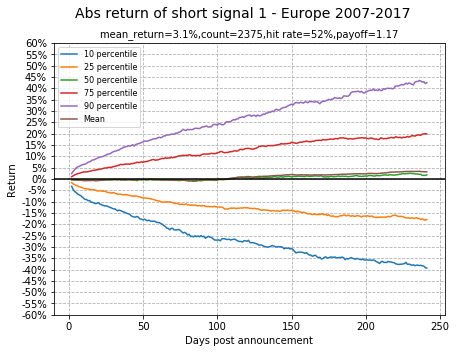

In [184]:
perf_chart_day(signal1_df_day(signal1_short_Europe,signal1_short_next_Europe,abs_return_Europe,240,True,2)
               ,"Days post announcement","Return","Abs return of short signal 1 - Europe 2007-2017",[7,5],
               [0.1,0.25,0.5,0.75,0.9])

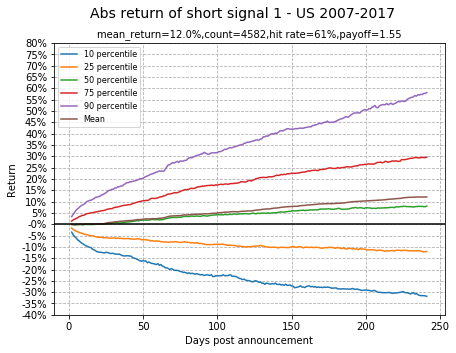

In [187]:
perf_chart_day(signal1_df_day(signal1_short_US,signal1_short_next_US,abs_return_US,240,True,2)
               ,"Days post announcement","Return","Abs return of short signal 1 - US 2007-2017",[7,5],
               [0.1,0.25,0.5,0.75,0.9])

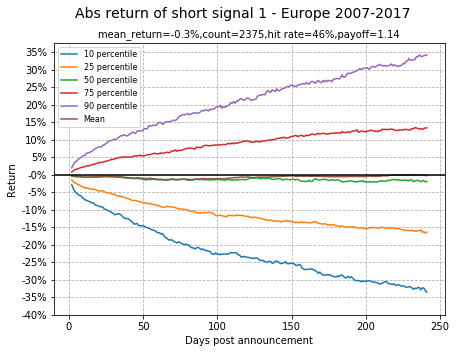

In [193]:
perf_chart_day(signal1_df_day(signal1_short_Europe,signal1_short_Europe_next,rel_return_Europe,240,True,2)
               ,"Days post announcement","Return","Abs return of short signal 1 - Europe 2007-2017",[7,5],
               [0.1,0.25,0.5,0.75,0.9])

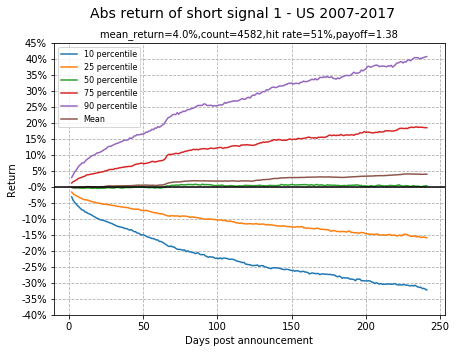

In [192]:
perf_chart_day(signal1_df_day(signal1_short_US,signal1_short_next_US,rel_return_US,240,True,2)
               ,"Days post announcement","Return","Abs return of short signal 1 - US 2007-2017",[7,5],
               [0.1,0.25,0.5,0.75,0.9])

## Short signal by date

In [249]:
# singal1 short dataframe by actual date US
signal1_rel_df_date_short_US=signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,120,False,False,2)
signal1_abs_df_date_short_US=signal1_df_date(data_dict_US['Date'],rel_return_US,abs_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,120,False,False,2)

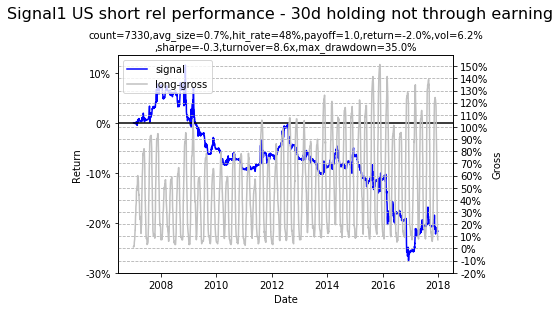

In [244]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,30,False,False,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 30d holding not through earning",[6,4])

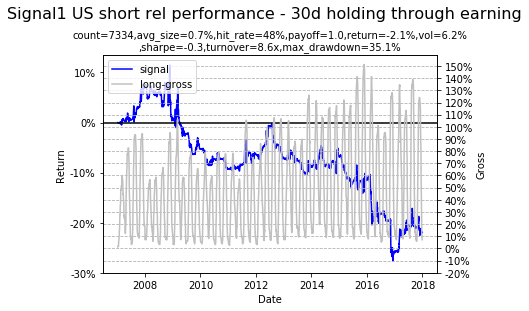

In [248]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,30,True,True,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 30d holding through earning",[6,4])

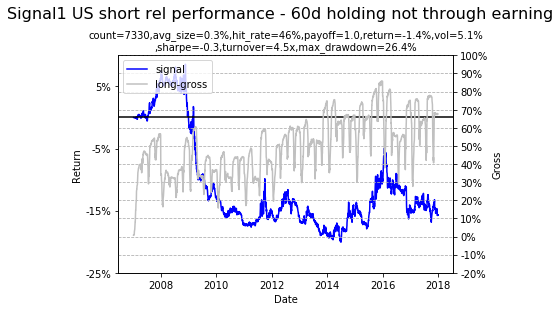

In [243]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,60,False,False,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 60d holding not through earning",[6,4])

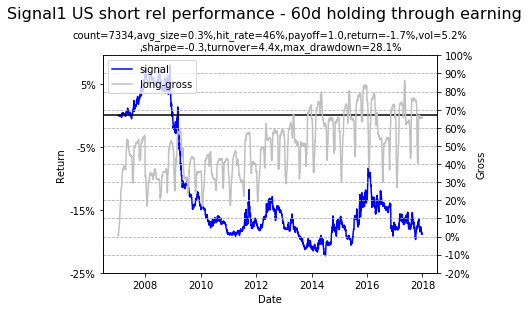

In [242]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,60,True,True,2)
                                   ,50,100,data_dict_US["Volume"],daata_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 60d holding through earning",[6,4])

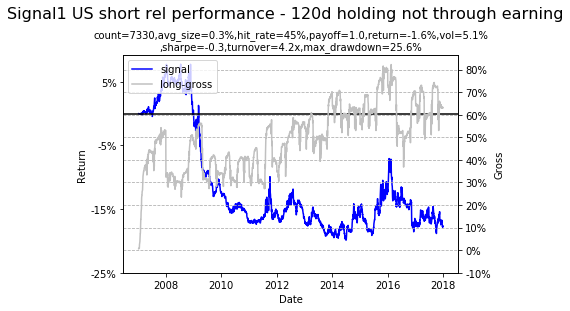

In [239]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,120,False,False,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 120d holding not through earning",[6,4])

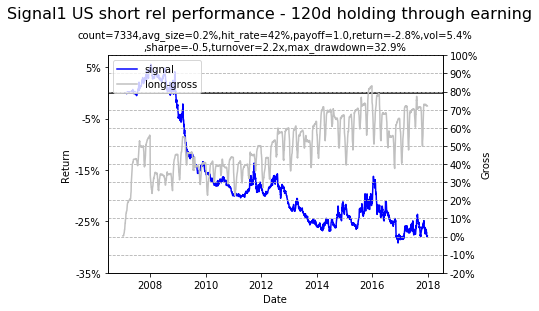

In [241]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,120,True,True,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 120d holding through earning",[6,4])

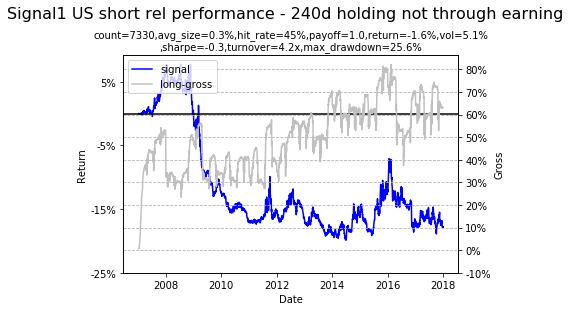

In [246]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,240,False,False,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 240d holding not through earning",[6,4])

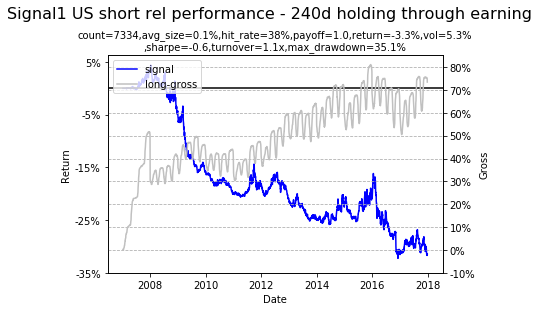

In [247]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,240,True,True,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 240d holding through earning",[6,4])

## Short signal performance by size

In [ ]:
plot_account_curve_by_size([0,0.25,0.5,0.75,1],(6,18),18,
                            "Account curve of signal 1 by size groups",-signal1_rel_df_date_short_US,
                            50,30,data_dict_US["Volume"],data_dict_US["Date"],data_dict_US["Market cap"],0.1)

In [256]:
data_dict_US["Market cap"]

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1570117D US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A US,22515.0871,19081.0174,18074.6347,16228.4941,14727.0684,15765.0158,14074.4473,12153.6705,12371.2825,12934.5034,...,14385.1577,14495.1973,13772.5649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AA US,8802.2127,6724.7663,6135.8605,6859.9125,12237.4167,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAL US,23259.8399,24589.0953,21664.0557,24325.9773,21030.7012,19267.6509,22091.9427,24576.3936,28786.9684,26624.2487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAN US,2769.6496,3359.1819,2560.2076,1923.2748,1770.5577,1742.3704,1906.7527,1594.1363,1790.5067,2535.0169,...,1451.2085,1564.0750,1620.8622,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAON US,1802.2886,1772.7421,1959.3623,1681.8906,1453.4069,1362.8127,1483.5903,1295.4655,1173.2737,1236.9986,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAP US,7073.5207,6431.9542,9822.8184,11869.2817,10523.1799,11798.3909,10555.4586,10136.6771,12054.5127,13742.1399,...,3453.4847,4280.5906,4078.3754,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAPL US,868326.4791,782336.6920,773917.1212,638035.9616,637183.3695,529502.6559,578577.2369,554393.2368,653246.8243,745981.0372,...,118722.7622,82178.0459,81677.8804,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAWW US,1417.1178,1687.7520,1347.7757,1407.0900,1064.1589,NaN,1207.3041,NaN,NaN,1219.0717,...,1155.6195,1260.5670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [262]:
plot_account_curve_by_size??

In [259]:
size_row_date=signal1_rel_df_date_short_US.apply(lambda x: get_market_cap(x.name,data_dict_US["Market cap"],data_dict_US["Date"]),axis=0)

In [261]:
size_row_date.quantile([0,0.25,0.5,0.75,1])

0.00      1000.053100
0.25      1970.775450
0.50      3433.460800
0.75      7732.352025
1.00    578577.236900
dtype: float64